In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fonts = fm.findSystemFonts()

for font in fonts:
    fm.fontManager.addfont(font)

font_size = 11
font_family = 'Times New Roman'
plot_style = 'seaborn-v0_8-paper'
# plot_style = 'fivethirtyeight'

plt.style.use(plot_style)
plt.rcParams['grid.alpha'] = 0.25
plt.rcParams['font.family'] = font_family
# plt.rcParams['font.size'] = font_size
# plt.rcParams['axes.labelsize'] = font_size
# plt.rcParams['xtick.labelsize'] = font_size
# plt.rcParams['ytick.labelsize'] = font_size
# plt.rcParams['legend.fontsize'] = font_size
# plt.rcParams['figure.titlesize'] = font_size
# plt.rcParams['axes.titlesize'] = font_size + 1
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['figure.constrained_layout.use'] = True

In [15]:
def create_composite_feature(dataframe, feature_list, new_feature_name, drop_features=False):
    """
    Create a composite feature from a list of features.
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe containing the features.
    feature_list : list
        The list of features to combine.
    new_feature_name : str
        The name of the new feature.
    drop_features : bool, default False
        Whether to drop the features used to create the new feature.
        
    Returns
    -------
    dataframe : pandas.DataFrame
        The dataframe with the new feature added.
    """    
    dataframe[new_feature_name] = dataframe[feature_list].mean(axis=1)
    if drop_features:
        dataframe.drop(columns=feature_list, inplace=True)
    return dataframe


def engineer_change_features(dataframe, drop_before_after=False):
    """
    Create change features from before and after features.
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe containing the features.
    drop_before_after : bool, default False
        Whether to drop the before and after features.
        
    Returns
    -------
    dataframe : pandas.DataFrame
        The dataframe with the change features added.
        
    Notes
    -----
    The change features are created by subtracting the before feature from the after feature.
    
    The change features are inserted after the after feature.
    
    Examples
    --------
    >>> import pandas as pd
    >>> df = pd.DataFrame({'a_before': [1, 2, 3],
                           'a_after': [4, 5, 6],
                           'b_before': [7, 8, 9],
                           'b_after': [10, 11, 12]})
    >>> df = engineer_change_features(df)
    """
    for col in dataframe.columns:
        if col.endswith('_before') or col.endswith('_after'):
            base_col = col.rsplit('_', 1)[0]
            before_col = base_col + '_before'
            after_col = base_col + '_after'
            if before_col in dataframe.columns and after_col in dataframe.columns:
                change_col = base_col + '_change'
                dataframe[change_col] = dataframe[after_col] - dataframe[before_col]
                change_col_index = max(dataframe.columns.get_loc(before_col), dataframe.columns.get_loc(after_col)) + 1
                change_col_data = dataframe[change_col]
                dataframe.drop(columns=[change_col], inplace=True)
                dataframe.insert(change_col_index, change_col, change_col_data)
                if drop_before_after:
                    dataframe.drop(columns=[before_col, after_col], inplace=True)
    return dataframe

In [16]:
survey = pd.read_excel('../data/raw/NARIG_Survey.xlsx', usecols='A:EG')
column_names = pd.read_json('../data/processed/json/column_names.json', typ='series')

kenya = gpd.read_file('../data/processed/geojson/kenya.geojson')
counties = gpd.read_file('../data/processed/geojson/kenya_counties.geojson')
sub_counties = gpd.read_file('../data/processed/geojson/kenya_sub_counties.geojson')
wards = gpd.read_file('../data/processed/geojson/kenya_wards.geojson')
kenya.crs = counties.crs = sub_counties.crs = wards.crs = 'EPSG:4326'
makueni_county = counties[counties['county'] == 'Makueni']
makueni_sub_counties = sub_counties[sub_counties['county'] == 'Makueni']
makueni_wards = wards[wards['county'] == 'Makueni']

survey.rename(columns=column_names, inplace=True)

replace_map = {'Diasgree': 'Disagree',
               '6+': 6,
               'Kako': 'Waia/Kako',
               'Mtito': 'Mtito Andei'}

ordinal_map = {'Strongly Agree': 5,
               'Agree': 4,
               'Neutral': 3,
               'Disagree': 2,
               'Strongly Disagree': 1}

reverse_map = {v: k for k, v in ordinal_map.items()}

survey.replace(replace_map, inplace=True)
survey.replace(ordinal_map, inplace=True)

survey = makueni_wards.merge(survey, on='ward', how='right')

survey['age'] = survey['age'].replace(0, np.nan)
survey['gender'] = survey['gender'].str.split().str[-1]

orig_col_order = list(survey.columns)

demographic_cols = survey.columns[:12].tolist()
attitude_cols = survey.columns[12:20].tolist()
knowledge_cols = survey.columns[20:25].tolist()
practice_cols = survey.columns[25:30].tolist()
# vc_performance_cols = survey.columns[30:-6].tolist()
performance_cols = survey.columns[-6:].tolist()

value_chains = list(survey['value_chain'].unique())

narig_dfs = {vc: survey[survey['value_chain'] == vc].dropna(axis=1, how='all') for vc in value_chains}

for k, v in narig_dfs.items():
    v.columns = v.columns.str.replace('_\d', '', regex=True)
    # v.dropna(axis=0, inplace=True)
    # v = create_composite_feature(v, attitude_cols, 'farmer_attitudes')
    # v = create_composite_feature(v, knowledge_cols, 'farmer_knowledge')
    # v = create_composite_feature(v, practice_cols, 'farmer_practices')
    # v = create_composite_feature(v, performance_cols, 'project_performance')
    # v = engineer_change_features(v)

narig_dfs['survey_df'] = pd.concat(narig_dfs.values(), ignore_index=True)
narig_dfs['survey_df'] = narig_dfs['survey_df'][[col for col in orig_col_order if col in narig_dfs['survey_df'].columns]]

narig_dfs['survey_df'].replace(reverse_map, inplace=True)
numeric_cols = narig_dfs['survey_df'].select_dtypes('number').columns.tolist()
narig_dfs['survey_df'].replace(ordinal_map, inplace=True)

narig_dfs['survey_df'] = engineer_change_features(narig_dfs['survey_df'], drop_before_after=False)
narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], attitude_cols, 'farmer_attitudes', drop_features=False)
narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], knowledge_cols, 'farmer_knowledge', drop_features=False)
narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], practice_cols, 'farmer_practices', drop_features=False)
narig_dfs['survey_df'] = create_composite_feature(narig_dfs['survey_df'], performance_cols, 'project_performance', drop_features=False)

for k, v in narig_dfs.items():
    for col in v.select_dtypes('object').columns:
        v[col] = v[col].astype('category')
    for col in v.select_dtypes('float').columns:
        if v[col].apply(float.is_integer).all():
            v[col] = v[col].astype(int)
    print(k)
    


Tomato
Mango
Green gram
Indigenous chicken
survey_df


In [17]:
narig_dfs['survey_df'].head()

,county,sub_county,ward,geometry,gender,age,education,monthly_income,household_size,family_head,...,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity,farmer_attitudes,farmer_knowledge,farmer_practices,project_performance
0,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,64.0,Secondary,30000,3,Yes,...,5,5,4,5,5,5,5.0,4.8,4.8,4.833333
1,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,67.0,Secondary,20000,4,Yes,...,5,5,5,5,5,5,5.0,5.0,4.8,5.000000
2,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,33.0,Primary,5000,3,No,...,5,5,5,5,5,5,5.0,5.0,4.8,5.000000
3,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,73.0,Primary,800,6,No,...,5,5,4,5,5,5,5.0,5.0,4.8,4.833333
4,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,71.0,Secondary,10000,5,Yes,...,5,5,5,5,5,5,5.0,5.0,5.0,5.000000


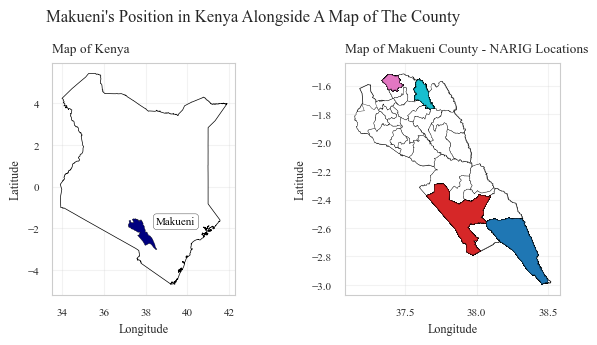

In [18]:
# Create a single figure
fig, ax = plt.subplots(1,2, figsize=(6, 3))

# Plot Kenya
kenya.plot(ax=ax[0], color='white', edgecolor='black', linewidth=0.5)
ax[0].set_title('Map of Kenya', y=1.01, loc='left')  # Set title alignment to left

# Plot Makueni County
makueni_county.plot(ax=ax[0], color='navy', edgecolor='black')

# Annotate Makueni County
centroid = makueni_county.iloc[0].geometry.centroid
annotation = ax[0].annotate('Makueni', xy=(centroid.x, centroid.y),
               xytext=(25, 5), textcoords="offset points", color='black', fontsize=8, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25))

# Plot Makueni County separately
makueni_county.plot(ax=ax[1], color='white', edgecolor='black', linewidth=0.5)
ax[1].set_title('Map of Makueni County - NARIG Locations', y=1.01, loc='left')  # Set title alignment to left

# Plot Makueni wards
makueni_wards.plot(ax=ax[1], color='white', edgecolor='black', linewidth=0.25)

# Annotate Makueni County in the second plot
# annotation2 = ax[1].annotate('Makueni', xy=(makueni_county.geometry.centroid.x, makueni_county.geometry.centroid.y),
#xytext=(30, 0), textcoords="offset points", color='black', fontsize=8, ha='center')

# Plot survey points
survey.plot('ward', ax=ax[1], edgecolor='black', legend=False)

# Remove legend border


# Add titles and labels
fig.suptitle("Makueni's Position in Kenya Alongside A Map of The County", x=0.08, y=1.1, ha='left')  # Set title alignment to left
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# Add scale bar
#scalebar = gpd.GeoSeries(LineString([(0.9, 0.1), (1.1, 0.1)]), crs=kenya.crs)
#scalebar.plot(ax=ax[0], color='black', linewidth=2)

# Move legend lower
# ax[1].get_legend().set_bbox_to_anchor((0.525, 0.33))
# # ax[1].get_legend().set_title('Ward')
# # Reduce the size of the legend
# ax[1].get_legend().get_title().set_fontsize(8)
# for t in ax[1].get_legend().texts:
#     t.set_fontsize(8)

# Remove axes
# ax[0].set_axis_off()
# ax[1].set_axis_off()

# Add a border to the figure
fig.patch.set_edgecolor('black')

plt.show()

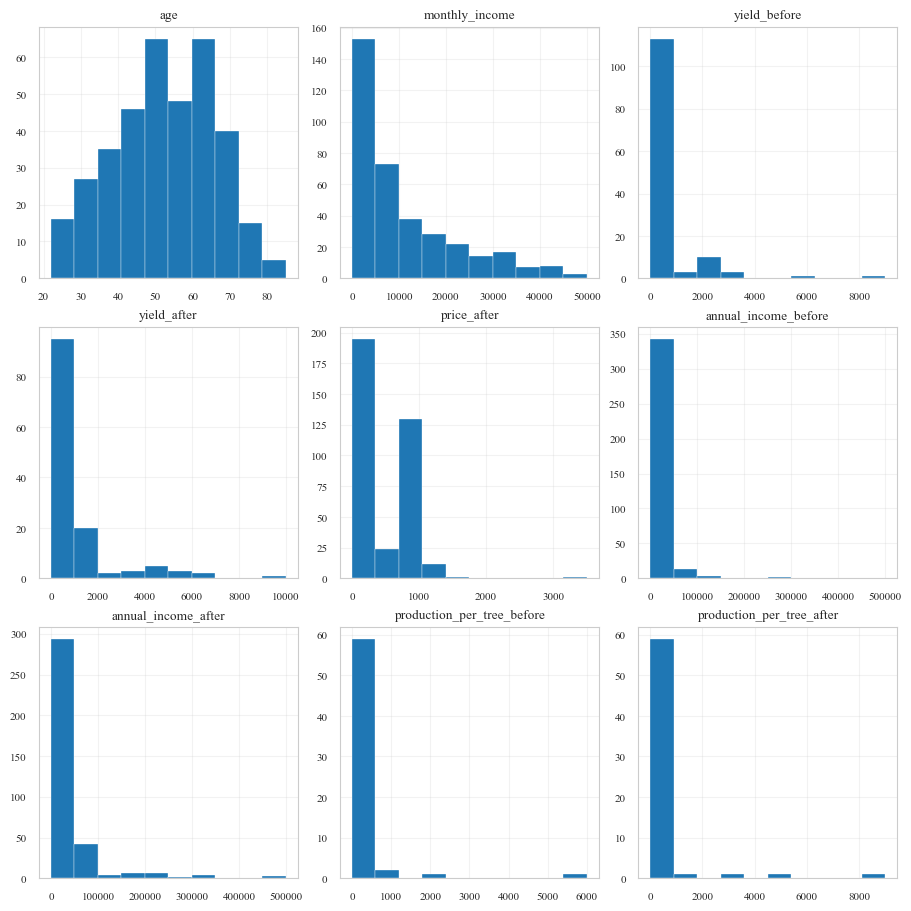

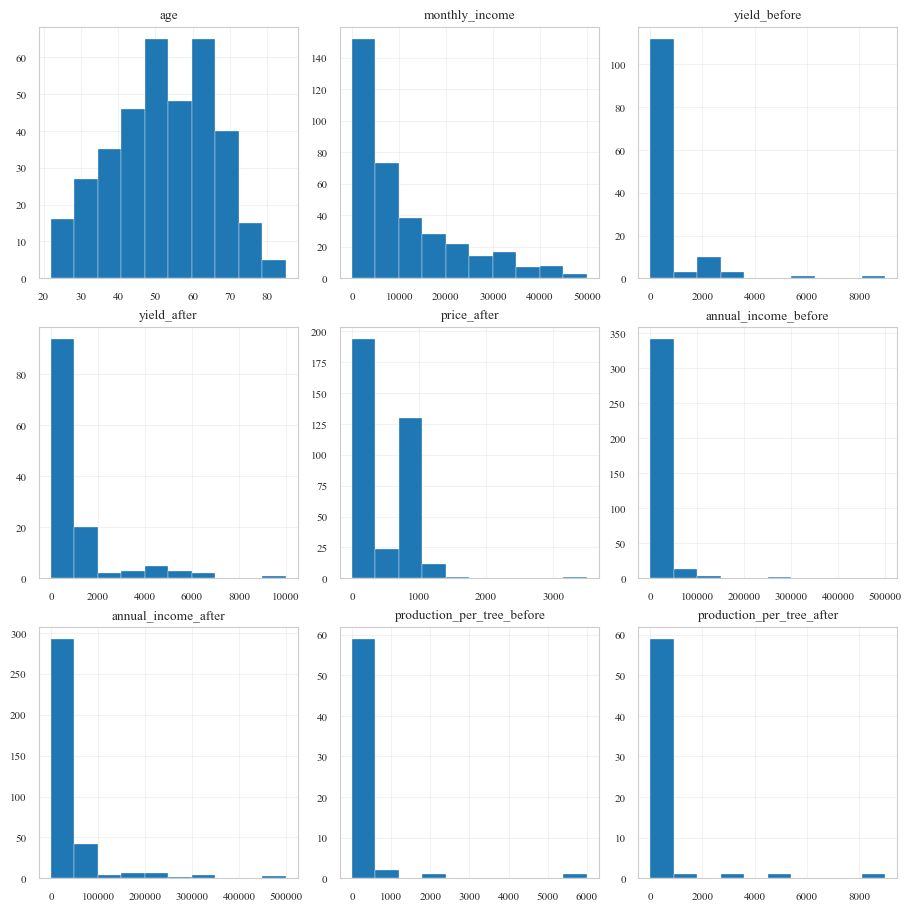

In [19]:
narig_dfs['survey_df'][numeric_cols].hist(figsize=(9,9))
plt.show()


def filter_outliers(dataframe: pd.DataFrame, columns: list):
    
    for col in columns:
        
        mean = dataframe[col].mean()
        std = dataframe[col].std()
        limit = std * 3

        lower, upper = (mean - limit), (mean + limit)

        dataframe = dataframe[(dataframe[col] > lower) &
                                   (dataframe[col] < upper)]
        
        return dataframe
        
df_outliers = filter_outliers(narig_dfs['survey_df'], numeric_cols)

df_outliers[numeric_cols].hist(figsize=(9,9))
plt.show()


# survey.hist('vc_experience')
# plt.show()

# mean_vce = survey.vc_experience.mean()
# print(mean_vce)
# std_vce = survey.vc_experience.std()
# print(std_vce)
# limit = std_vce * 3
# print(limit)
# lower, upper = mean_vce - limit, mean_vce + limit
# print(lower, ',', upper)

# survey = survey[survey['vc_experience'] < upper]


# # survey['vc_experience'] = survey.vc_experience ** 1/3

# survey.hist('vc_experience')
# plt.show()

# mean_vce = survey.vc_experience.mean()
# print(mean_vce)
# std_vce = survey.vc_experience.std()
# print(std_vce)
# limit = std_vce * 3
# print(limit)
# lower, upper = mean_vce - limit, mean_vce + limit
# print(lower, ',', upper)

# survey = survey[survey['vc_experience'] > upper]

# survey.hist('vc_experience')
# plt.show()

In [20]:
df_outliers.describe().round(2).T.map(lambda x: int(x) if x.is_integer() else x).rename(columns={'count': 'Count', 'mean': 'Mean', 'std': 'Standard Deviation', 'min': 'Minimum', '25%': '25th Percentile', '50%': '50th Percentile', '75%': '75th Percentile', 'max': 'Maximum'})

,Count,Mean,Standard Deviation,Minimum,25th Percentile,50th Percentile,75th Percentile,Maximum
age,362,52.37,13.42,22.00,42.25,53.00,63.0,85
monthly_income,362,10022.79,10626.38,0.00,3000.00,5000.00,15000.0,50000
household_size,362,4.25,1.52,1.00,3.00,4.00,6.0,6
vc_experience,362,7.61,6.82,1.00,4.00,5.00,8.0,50
project_skepticism,362,4.29,0.84,2.00,4.00,4.00,5.0,5
...,...,...,...,...,...,...,...,...
project_inclusivity,362,4.45,0.56,1.00,4.00,4.00,5.0,5
farmer_attitudes,362,4.41,0.45,3.38,4.00,4.38,5.0,5
farmer_knowledge,362,4.42,0.47,2.80,4.00,4.40,5.0,5
farmer_practices,362,4.08,0.64,2.40,3.60,4.00,4.8,5


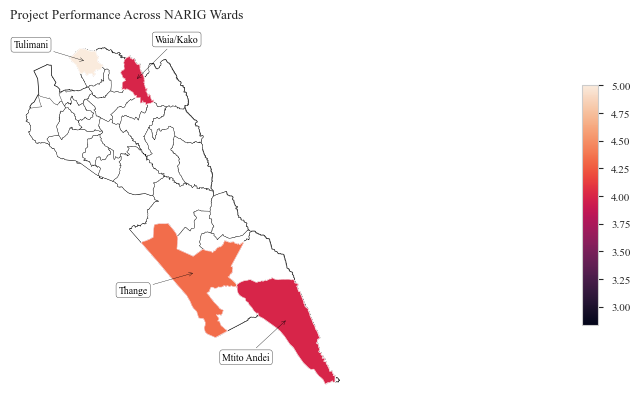

In [21]:
# Plot project_performance on the map
fig, ax = plt.subplots(figsize=(8, 4))

makueni_county.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)
makueni_wards.plot(ax=ax, color='white', edgecolor='black', linewidth=0.25)
cax = fig.add_axes([1, 0.2, 0.02, 0.6])  # Reduce the width of the colorbar axes
df_outliers.plot('project_performance', legend=True, ax=ax, cax=cax)  # Add cax parameter to specify the colorbar axes

# Add title and labels
ax.set_title('Project Performance Across NARIG Wards', y=1.01, loc='left')  # Set title alignment to left

# Get unique geometries from the dataframe
unique_geometries = df_outliers.drop_duplicates(subset='geometry')

# Add annotations individually
tulimani = unique_geometries[unique_geometries['ward'] == 'Tulimani']
tulimani_centroid = tulimani.iloc[0].geometry.centroid
ax.annotate('Tulimani', xy=(tulimani_centroid.x, tulimani_centroid.y),
            xytext=(-40, 10), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

kako = unique_geometries[unique_geometries['ward'] == 'Waia/Kako']
kako_centroid = kako.iloc[0].geometry.centroid
ax.annotate('Waia/Kako', xy=(kako_centroid.x, kako_centroid.y),
            xytext=(30, 27.5), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

mtito = unique_geometries[unique_geometries['ward'] == 'Mtito Andei']
mtito_centroid = mtito.iloc[0].geometry.centroid
ax.annotate('Mtito Andei', xy=(mtito_centroid.x, mtito_centroid.y),
            xytext=(-30, -30), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

thange = unique_geometries[unique_geometries['ward'] == 'Thange']
thange_centroid = thange.iloc[0].geometry.centroid
ax.annotate('Thange', xy=(thange_centroid.x, thange_centroid.y),
            xytext=(-45, -15), textcoords="offset points", color='black', fontsize=7, ha='center',
            bbox=dict(boxstyle='round', fc='white', ec='black', pad=0.25),
            arrowprops=dict(arrowstyle='->', color='black'))

# Remove axes
ax.set_axis_off()

plt.show()

In [22]:
# # Cuberoot
# for col in df_outliers.select_dtypes('number').columns:
#     df_outliers[col] = df_outliers[col] ** 1/3

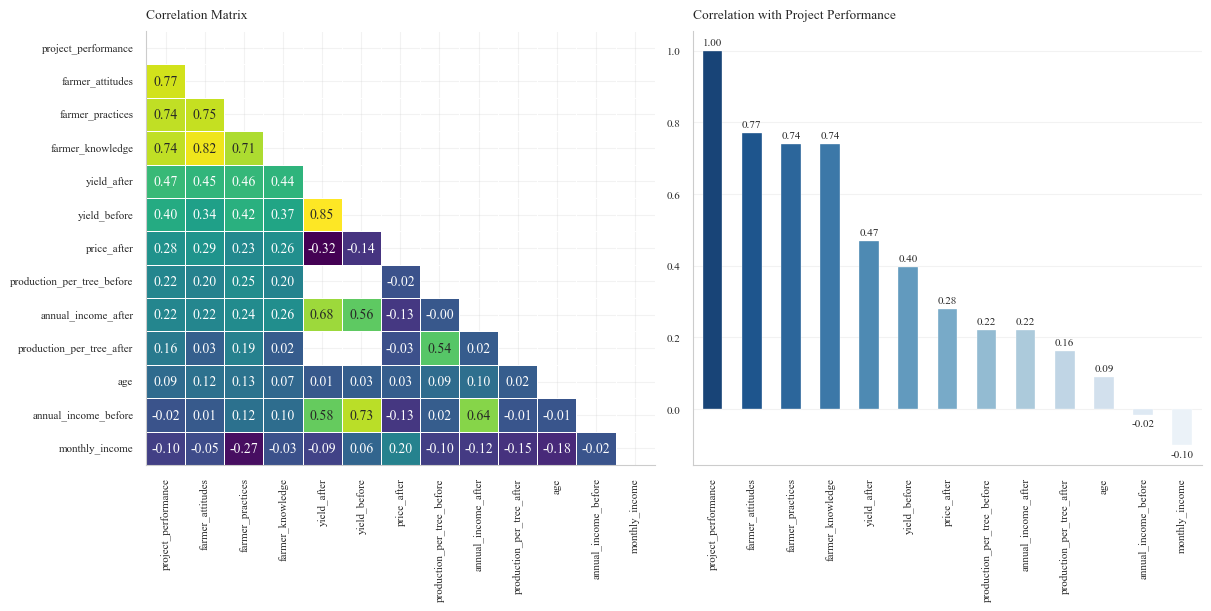

In [23]:
corr = df_outliers[numeric_cols + ['farmer_attitudes', 'farmer_knowledge', 'farmer_practices', 'project_performance']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Sort the correlation matrix by project_performance (both axes)
corr = corr.sort_values(by='project_performance', ascending=False); corr = corr[corr.index]

sns.heatmap(corr, mask=mask, cmap='viridis', linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=True, fmt='.2f', cbar=False, ax=ax[0])
ax[0].set_title('Correlation Matrix', y=1.01, loc='left')
sns.barplot(y=corr['project_performance'].sort_values(ascending=False).values, x=corr['project_performance'].sort_values(ascending=False).index, hue=corr['project_performance'], orient='v', palette=sns.color_palette('Blues', len(corr.columns)), width = 0.5, legend=False, ax=ax[1])
for i, v in enumerate(corr['project_performance'].sort_values(ascending=False).values):
    if v > 0:
        ax[1].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=8)
    else:
        ax[1].text(i, v - 0.01, f"{v:.2f}", ha='center', va='top', fontsize=8)

ax[1].set_xlabel('')
ax[1].set_title('Correlation with Project Performance', y=1.01, loc='left')
ax[1].xaxis.set_tick_params(rotation=90)

ax[0].tick_params(axis='x', which='both', bottom=False)
ax[1].tick_params(axis='x', which='both', bottom=False)

sns.despine()

plt.show()

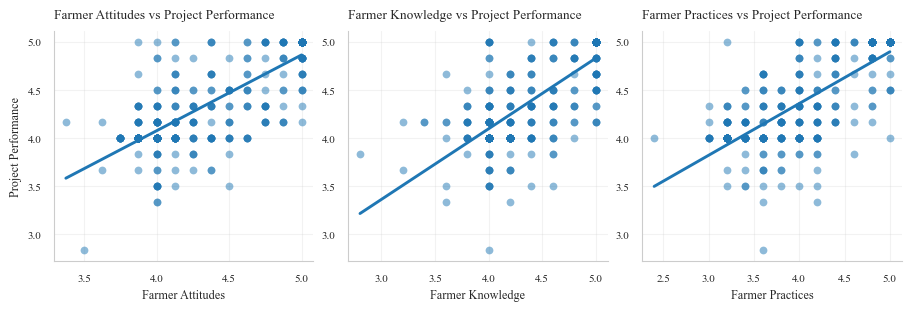

In [24]:
fig, ax = plt.subplots(1,3, figsize=(9, 3))

sns.regplot(data=df_outliers, x='farmer_attitudes', y='project_performance', ax=ax[0], scatter_kws={'alpha': 0.5}, logx=False, ci=None)
sns.regplot(data=df_outliers, x='farmer_knowledge', y='project_performance', ax=ax[1], scatter_kws={'alpha': 0.5}, logx=False, ci=None)
sns.regplot(data=df_outliers, x='farmer_practices', y='project_performance', ax=ax[2], scatter_kws={'alpha': 0.5}, logx=False, ci=None)


ax[0].set_title('Farmer Attitudes vs Project Performance', y=1.02, loc='left')
ax[1].set_title('Farmer Knowledge vs Project Performance', y=1.02, loc='left')
ax[2].set_title('Farmer Practices vs Project Performance', y=1.02, loc='left')

ax[0].set_xlabel('Farmer Attitudes')
ax[1].set_xlabel('Farmer Knowledge')
ax[2].set_xlabel('Farmer Practices')

ax[0].set_ylabel('Project Performance')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

sns.despine()

plt.show()

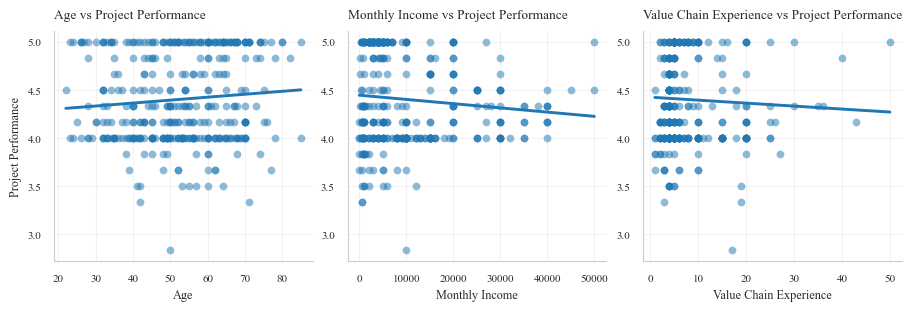

In [25]:
fig, ax = plt.subplots(1,3, figsize=(9, 3))

sns.regplot(data=df_outliers, x='age', y='project_performance', ax=ax[0], scatter_kws={'alpha': 0.5}, logx=False, ci=None)
sns.regplot(data=df_outliers, x='monthly_income', y='project_performance', ax=ax[1], scatter_kws={'alpha': 0.5}, logx=False, ci=None)
sns.regplot(data=df_outliers, x='vc_experience', y='project_performance', ax=ax[2], scatter_kws={'alpha': 0.5}, logx=False, ci=None)

ax[0].set_title('Age vs Project Performance', y=1.02, loc='left')
ax[1].set_title('Monthly Income vs Project Performance', y=1.02, loc='left')
ax[2].set_title('Value Chain Experience vs Project Performance', y=1.02, loc='left')

ax[0].set_xlabel('Age')
ax[1].set_xlabel('Monthly Income')
ax[2].set_xlabel('Value Chain Experience')

ax[0].set_ylabel('Project Performance')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

sns.despine()

plt.show()

array([[<Axes: title={'left': 'Value Chain vs Project Performance'}, xlabel='value_chain', ylabel='project_performance'>,
        <Axes: title={'left': 'Education vs Project Performance'}, xlabel='education', ylabel='project_performance'>],
       [<Axes: xlabel='gender', ylabel='project_performance'>,
        <Axes: xlabel='family_head', ylabel='project_performance'>]],
      dtype=object)

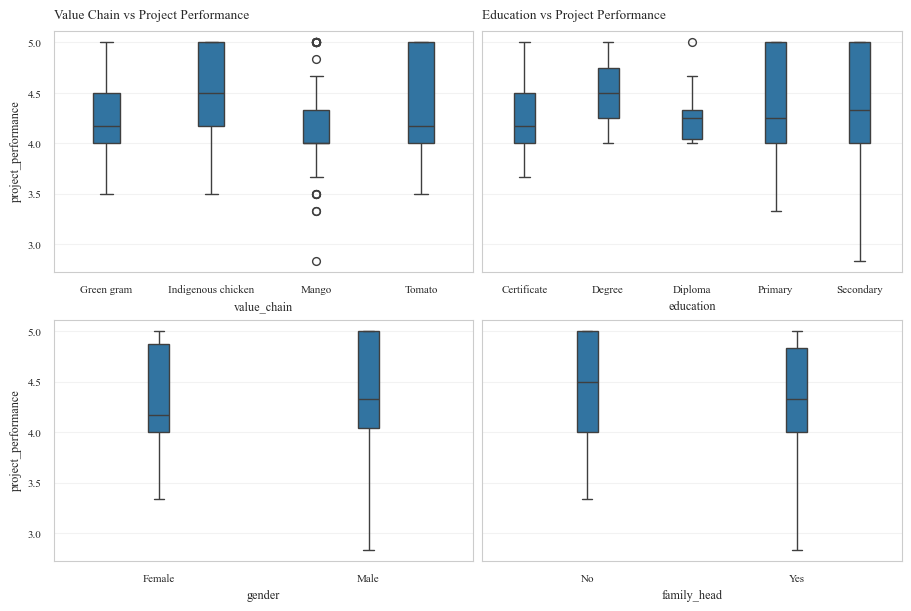

In [26]:
# Create a figure with boxplots for demographic data against project_performance
fig, ax = plt.subplots(2, 2, figsize=(9, 6), sharey=True)

sns.boxplot(data=df_outliers, x='value_chain', y='project_performance', width=0.25, ax=ax[0,0])
sns.boxplot(data=df_outliers, x='education', y='project_performance', width=0.25, ax=ax[0,1])
sns.boxplot(data=df_outliers, x='gender', y='project_performance', width=0.1, ax=ax[1,0])
sns.boxplot(data=df_outliers, x='family_head', y='project_performance', width=0.1, ax=ax[1,1])

ax[0,0].set_title('Value Chain vs Project Performance', y=1.02, loc='left')
ax[0,1].set_title('Education vs Project Performance', y=1.02, loc='left')
ax